In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.linalg import cholesky, lstsq


In [3]:
from experiments import EffectCorrelation
from experiments import utilities as utils
from bayesinverse import Regression


In [4]:

config_path = config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/effect_correlation/config.yaml"
)

exp = EffectCorrelation(config_path)


sensors 0.012709662318229675
emissions 1.930572271347046
transport 4.780395865440369


In [5]:
meteo_seed = 2
n_processes = 32
exp.K = exp.transport.get_transport(
    exp.sensors.n_sensors, exp.sensors.get_index(), exp.emissions, n_processes=n_processes, seed=meteo_seed
)


loop start 34.85472469031811
loop end 34.91518719494343


In [6]:
reg = Regression(
    y=utils.stack_xr(exp.K @ exp.emissions.truth + exp.sensors.get_noise()),
    K=utils.stack_xr(exp.K),
    x_prior=utils.stack_xr(exp.emissions.prior),
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance),
    y_covariance=utils.stack_xr(exp.sensors.get_covariance()),
)


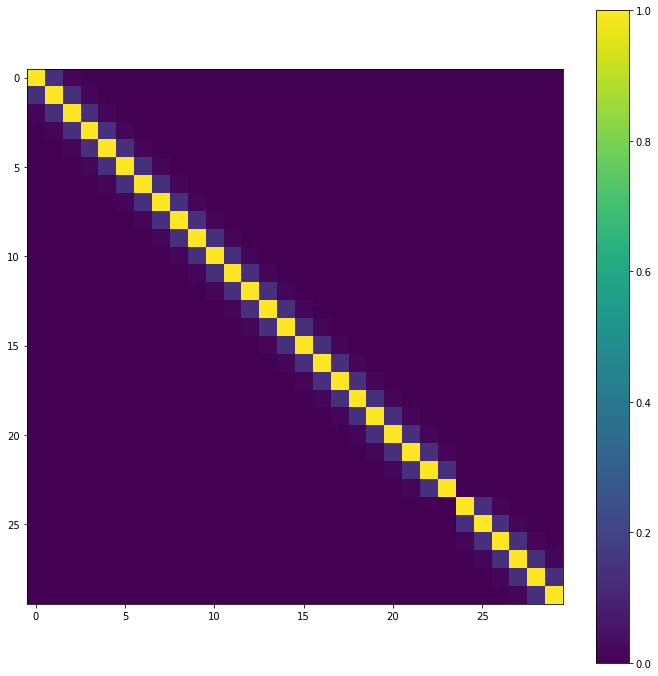

In [7]:
plt.figure(figsize=(12,12))
plt.imshow(utils.stack_xr(exp.emissions.prior_covariance)[:30, :30])
plt.colorbar()


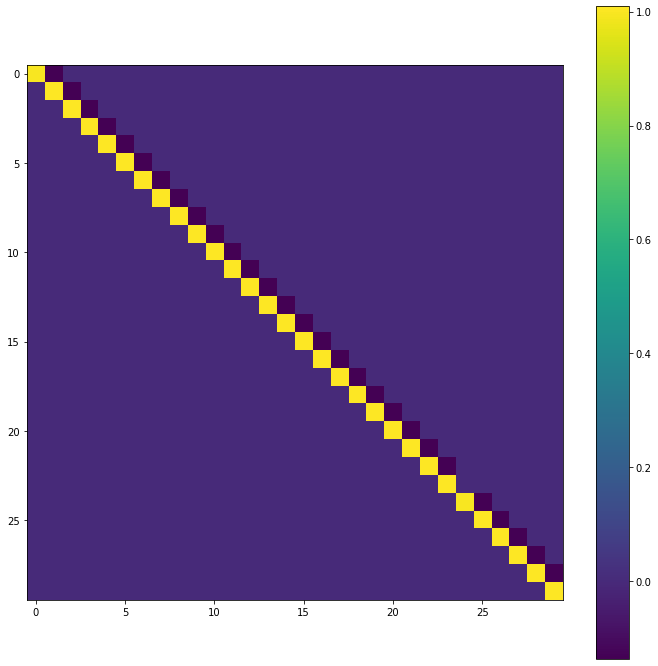

In [8]:
plt.figure(figsize=(12,12))
plt.imshow(reg.model.x_covariance_inv_sqrt[:30, :30])
plt.colorbar()


In [9]:
reg.get_averaging_kernel().min()

-3.2590847905277522

In [10]:
true_emissions = exp.emissions.get_absolute()[exp.emissions.mask]


In [11]:
corr_strength_list = [1e-8 + 1.0 * i for i in range(30)]
tau_h = 1.
tau_d = .00001

reg = Regression(
    y=utils.stack_xr(exp.K @ exp.emissions.truth + exp.sensors.get_noise()),
    K=utils.stack_xr(exp.K),
    x_prior=utils.stack_xr(exp.emissions.prior),
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance),
    y_covariance=utils.stack_xr(exp.sensors.get_covariance()),
)

rmse_list = []
posterior_list = []
posterior_covariance_list = []
for corr_strength in corr_strength_list:
    print(corr_strength)
    prior_covariance = utils.compute_prior_covariance(
        xr_prior_var=exp.emissions.prior_variance,
        tau_h=corr_strength * tau_h,
        tau_d=corr_strength * tau_d,
    )
    reg.set_x_covariance(utils.stack_xr(prior_covariance))
    x_est, _, _, _ = reg.fit()
    x_posterior = exp.emissions.to_xr(x_est)
    x_posterior = utils.unstack_xr(x_posterior) * true_emissions

    error = x_posterior - exp.emissions.truth_absolute
    rmse = np.sqrt(np.mean(error.sum("source_group")**2))
    # rmse = np.mean(
    #     np.abs(
    #         (
    #             exp.emissions.truth_absolute.sum("source_group")
    #             - (utils.unstack_xr(x_posterior) * exp.emissions.truth_absolute).sum(
    #                 "source_group"
    #             )
    #         )
    #     )
    # )
    rmse_list.append(rmse)
    posterior_list.append(x_posterior)
    posterior_covariance_list.append(reg.get_posterior_covariance())


1e-08
1.00000001


KeyboardInterrupt: 

Saving data

In [ ]:
# Save data
exp.data["rmse_list"] = rmse_list
exp.data["posterior_list"] = posterior_list
exp.data["posterior_covariance_list"] = posterior_covariance_list
exp.data["corr_strength_list"] = corr_strength_list
exp.pickle_data()

NameError: name 'rmse_list' is not defined